In [118]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from stompy.grid import unstructured_grid
import stompy.model.data_comparison as dc
from stompy import utils

import stompy.model.delft.dflow_model as dfm
import pesca_base

import stompy.plot.cmap as scmap
from stompy.plot import plot_utils
turbo=scmap.load_gradient('turbo.cpt')
from matplotlib import cm
%matplotlib notebook

In [71]:
import six
six.moves.reload_module(dfm)
models=[]
for run_dir in ["run_flow_test-v01",
                "run_flow_test-v02"]:
    model=dfm.DFlowModel.load(run_dir)
    models.append(model)

In [47]:
bcs=model.load_bcs()
his=xr.open_dataset(model.his_output())

<IPython.core.display.Javascript object>


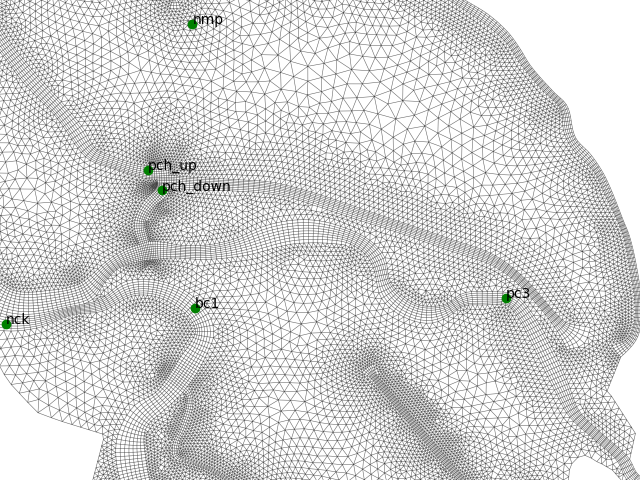

In [21]:
g=model.grid
fig,ax=plt.subplots()

ax.axis("off")
ax.axis('tight')
ax.set_position([0,0,1,1])
ax.axis('equal')


g.plot_edges(lw=0.4,color='k',alpha=0.6)

plt.plot( his.station_x_coordinate.values,
          his.station_y_coordinate.values, 
         'go')
for stn_i,station in enumerate(his.station_name.values):
    ax.text(his.station_x_coordinate.values[stn_i],
            his.station_y_coordinate.values[stn_i],
            station.decode())

# So let's plot lag1, pc3, ch2

In [48]:
Q_butano=[bc for bc in bcs if bc['name']=='butano_ck'][0]
Q_pesca= [bc for bc in bcs if bc['name']=='pescadero_ck'][0]

<IPython.core.display.Javascript object>


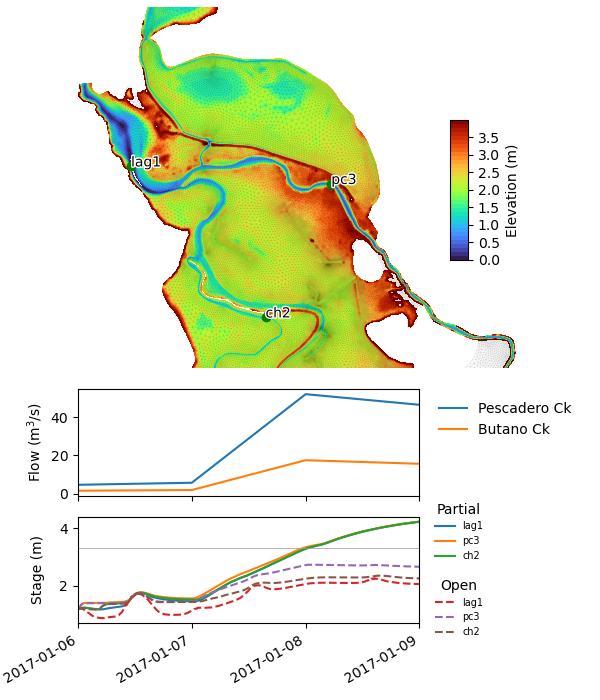

In [133]:
from matplotlib import gridspec
gs=gridspec.GridSpec(5,4)
fig=plt.figure(figsize=[6,7])
ax_map=fig.add_subplot(gs[:-2,:])
ax_t=fig.add_subplot(gs[-1,:-1])
ax_Q=fig.add_subplot(gs[-2,:-1],sharex=ax_t)

ax=ax_map
ax_map.axis("off")
ax_map.axis('tight')
ax_map.axis('equal')

g.plot_edges(lw=0.4,color='k',alpha=0.1,ax=ax_map)
cset=g.contourf_node_values(g.nodes['depth'],
                            np.linspace(0,4,36),
                            cmap=turbo,ax=ax_map)
pos=ax_map.get_position()

cax=fig.add_axes([pos.xmax-0.15,pos.ymin+0.2,0.03,0.2])
plt.colorbar(cset,cax=cax,label='Elevation (m)',
             ticks=np.arange(0,4,0.5))


stations=[b'lag1',b'pc3',b'ch2']

for model,ls,mouth_state in zip(models,['-','--'],['Constricted','Open']):
    his=xr.open_dataset(model.his_output())
    x=his.station_x_coordinate.values
    y=his.station_y_coordinate.values

    # Hack to label groups of labels
    #ax_t.plot(his.time,np.nan*np.ones(len(his.time)),
    #          lw=0,color='k',label=mouth_state)
    
    for station in stations:
        stn_i=np.nonzero( his.station_name.values==station)[0][0]

        if model==models[0]:
            ax_map.plot(x[stn_i], y[stn_i], 'go')
            ax_map.text(x[stn_i],y[stn_i], station.decode(),
                        path_effects=[pe.withStroke(foreground='1.0',linewidth=2.0)])


        wl=his.waterlevel.isel(stations=stn_i)
        ax_t.plot(his.time,wl,label=station.decode(),
                  ls=ls)
    
map_zoom=(552074., 553889., 4123820., 4124695.)
ax_map.axis(map_zoom)

ax_Q.plot(Q_pesca['data'].time,  Q_pesca['data'].flow,  label="Pescadero Ck")
ax_Q.plot(Q_butano['data'].time, Q_butano['data'].flow, label="Butano Ck")
ax_Q.set_ylabel('Flow (m$^3$/s)')

#ax_t.legend(loc='center left',bbox_to_anchor=[1.02,0.5],frameon=False)
handles,labels=ax_t.get_legend_handles_labels()
leg1=matplotlib.legend.Legend(ax_t,handles[:3],labels[:3],loc='lower left',
                              bbox_to_anchor=[1.02,0.5],title='Partial',
                              frameon=False,fontsize=7)
leg2=matplotlib.legend.Legend(ax_t,handles[3:],labels[3:],loc='upper left',
                              bbox_to_anchor=[1.02,0.5],title='Open',
                              frameon=False,fontsize=7)
ax_t.add_artist(leg1)
ax_t.add_artist(leg2)

ax_t.set_ylabel('Stage (m)')

ax_Q.legend(loc='upper left',bbox_to_anchor=[1.02,1.],frameon=False)

plt.setp(ax_Q.get_xticklabels(),visible=0)

ax_Q.axis(xmin=wl.time.min(),
          xmax=wl.time.max())

fig.align_ylabels([ax_t,ax_Q])

fig.subplots_adjust(left=0.13,top=0.99)

import matplotlib.dates as mdates
ax_t.xaxis.set_major_locator(mdates.DayLocator())

plt.setp(ax_t.get_xticklabels(),rotation=30,ha='right') ;
ax_t.axhline(3.3,color='0.6',lw=0.5)
fig.savefig('river_flow_test.png')

matplotlib.legend.Legend